In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import sys
sys.path.append('../src')

In [74]:
from spaceoracle.models.estimators import ViTEstimatorV2

In [75]:
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch

In [76]:
adata_train = anndata.read_h5ad('../data/slideseq/day3_1.h5ad')
adata_test = anndata.read_h5ad('../data/slideseq/day3_2.h5ad')

In [77]:
n_top_genes = 4000
min_cells = 10
min_counts = 350

adata_train.var_names_make_unique()
adata_train.var["mt"] = adata_train.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_train, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata_train, min_counts=min_counts)
adata_train = adata_train[adata_train.obs["pct_counts_mt"] < 20].copy()
adata_train = adata_train[:, ~adata_train.var["mt"]]
sc.pp.filter_genes(adata_train, min_cells=min_cells)

adata_train.layers["raw_count"] = adata_train.X

sc.pp.normalize_total(adata_train, inplace=True)
sc.pp.log1p(adata_train)
sc.pp.highly_variable_genes(
    adata_train, flavor="seurat", n_top_genes=n_top_genes)

adata_train = adata_train[:, adata_train.var.highly_variable]
adata_train

View of AnnData object with n_obs × n_vars = 9043 × 4000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [78]:
adata_test.var_names_make_unique()
adata_test.var["mt"] = adata_test.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_test, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata_test, min_counts=min_counts)
adata_test = adata_test[adata_test.obs["pct_counts_mt"] < 20].copy()
adata_test = adata_test[:, ~adata_test.var["mt"]]
sc.pp.filter_genes(adata_test, min_cells=min_cells)

adata_test.layers["raw_count"] = adata_test.X

sc.pp.normalize_total(adata_test, inplace=True)
sc.pp.log1p(adata_test)
sc.pp.highly_variable_genes(
    adata_test, flavor="seurat", n_top_genes=n_top_genes)

adata_test = adata_test[:, adata_test.var.highly_variable]
adata_test

View of AnnData object with n_obs × n_vars = 11411 × 4000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [79]:
np.intersect1d(adata_train.var_names, adata_test.var_names).__len__()

1725

In [80]:
adata_train = adata_train[:, adata_train.var_names.isin(np.intersect1d(adata_train.var_names, adata_test.var_names))]
adata_test = adata_test[:, adata_test.var_names.isin(np.intersect1d(adata_train.var_names, adata_test.var_names))]

adata_train, adata_test

(View of AnnData object with n_obs × n_vars = 9043 × 1725
     obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
     obsm: 'X_spatial', 'rctd_results', 'spatial'
     layers: 'raw_count',
 View of AnnData object with n_obs × n_vars = 11411 × 1725
     obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',

In [81]:
np.intersect1d(adata_train.var_names, adata_test.var_names).__len__()

1725

In [82]:
estimator = ViTEstimatorV2(adata_train, target_gene='Cd74')

In [83]:
estimator.regulators, len(estimator.regulators)

(['Atf3',
  'Bcl11a',
  'Ebf1',
  'Ebf3',
  'Hivep1',
  'Klf7',
  'Mef2a',
  'Mef2c',
  'Pax5',
  'Pou2f2',
  'Rreb1',
  'Rxra',
  'Stat2',
  'Taf1',
  'Tcf7l2'],
 15)

In [84]:
x = set(estimator.regulators) & set(estimator.adata.to_df().columns)
len(x)

15

In [85]:
estimator.fit(
    annot='rctd_cluster', 
    max_epochs=100, 
    learning_rate=0.0605356621516488, 
    spatial_dim=32,
    batch_size=16,
    init_betas='ones',
    mode='train_test',
    rotate_maps=False,
    regularize=False,
    n_patches=2, n_heads=8, n_blocks=4, hidden_d=16
)

[cuda] MSE: 0.4407 | Baseline: 1.4216:   3%|▎         | 3/100 [00:58<31:10, 19.28s/it]

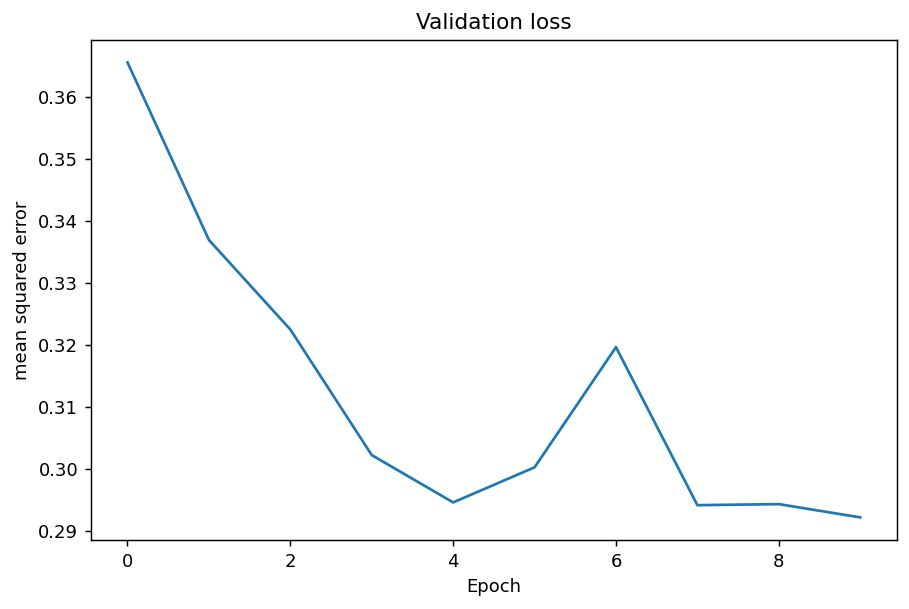

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title('Validation loss')
plt.show()

In [ ]:
with torch.no_grad():
    betas = estimator.get_betas(
        np.array(adata_train.obsm['spatial']),
        np.array(adata_train.obs['rctd_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(betas).cuda(), 
        torch.from_numpy(adata_train.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

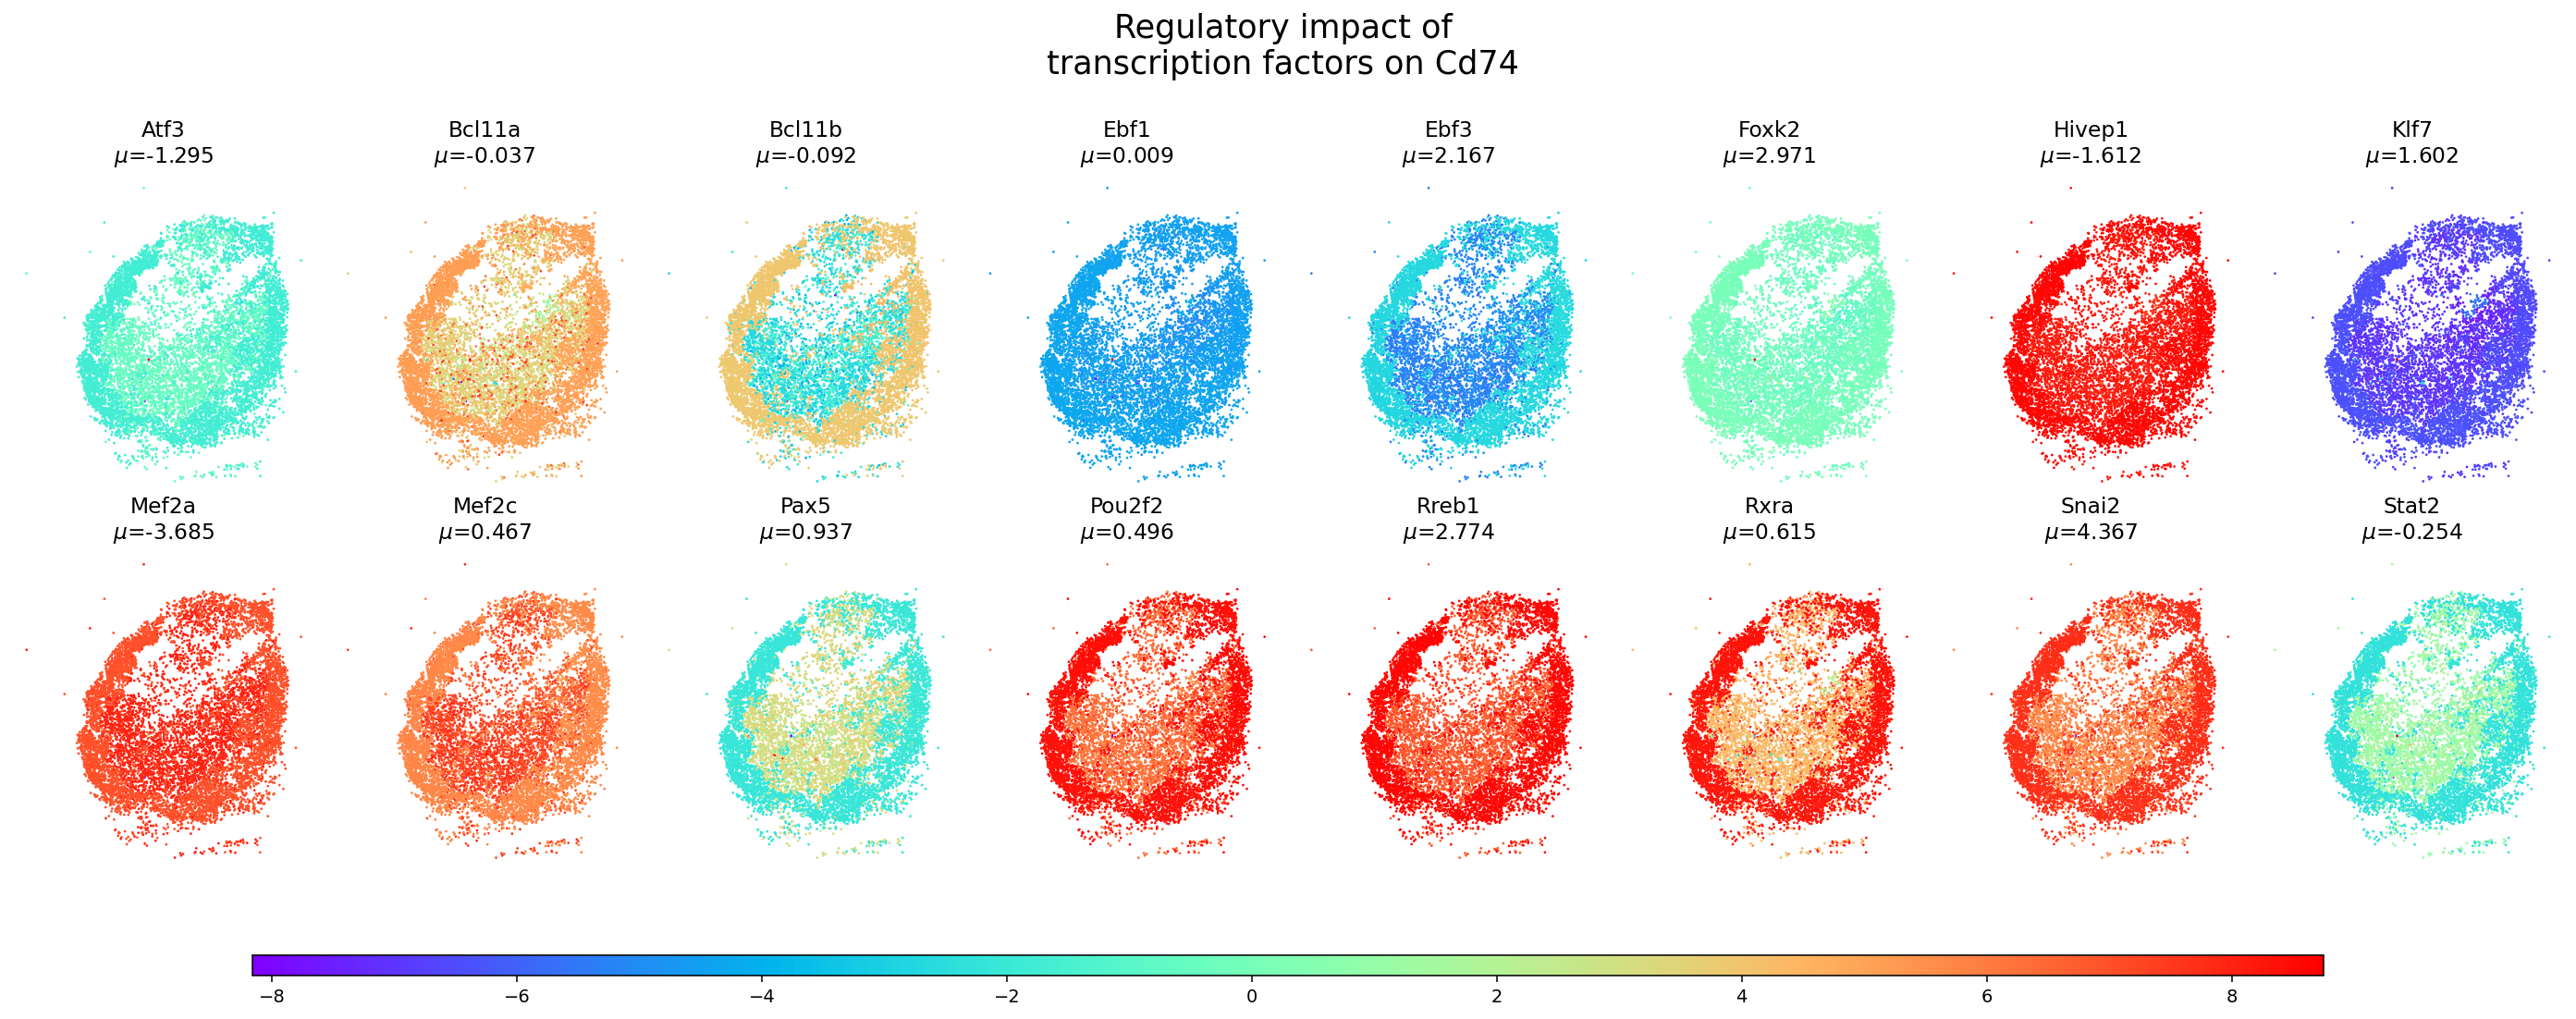

In [ ]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata_train.obsm['spatial'][:, 0], y=adata_train.obsm['spatial'][:, 1], 
                s=2, c=betas[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

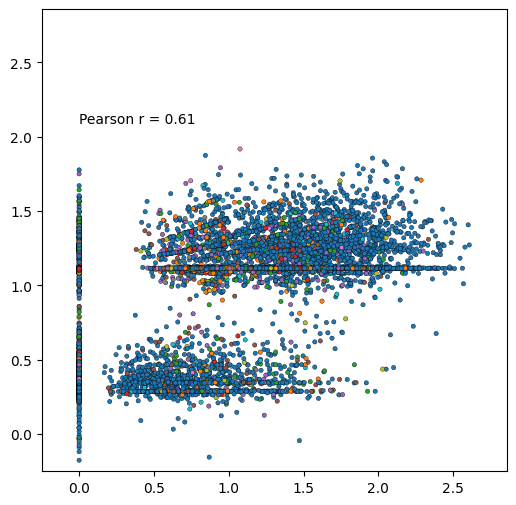

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = adata_train.to_df()[['Cd74']]
sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_train.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)
plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)

plt.show()

In [ ]:
with torch.no_grad():
    betas_test = estimator.get_betas(
        np.array(adata_test.obsm['spatial']),
        np.array(adata_test.obs['rctd_cluster']),
    )
    
    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(betas_test).cuda(), 
        torch.from_numpy(adata_test.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

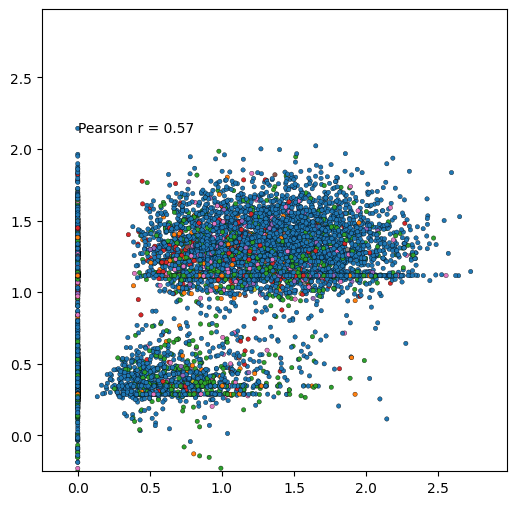

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = adata_test.to_df()[['Cd74']]
sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_test.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)
plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)

corr, _ = pearsonr(y.values.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.values.min(), 
    y=y_pred.max()+0.05, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()


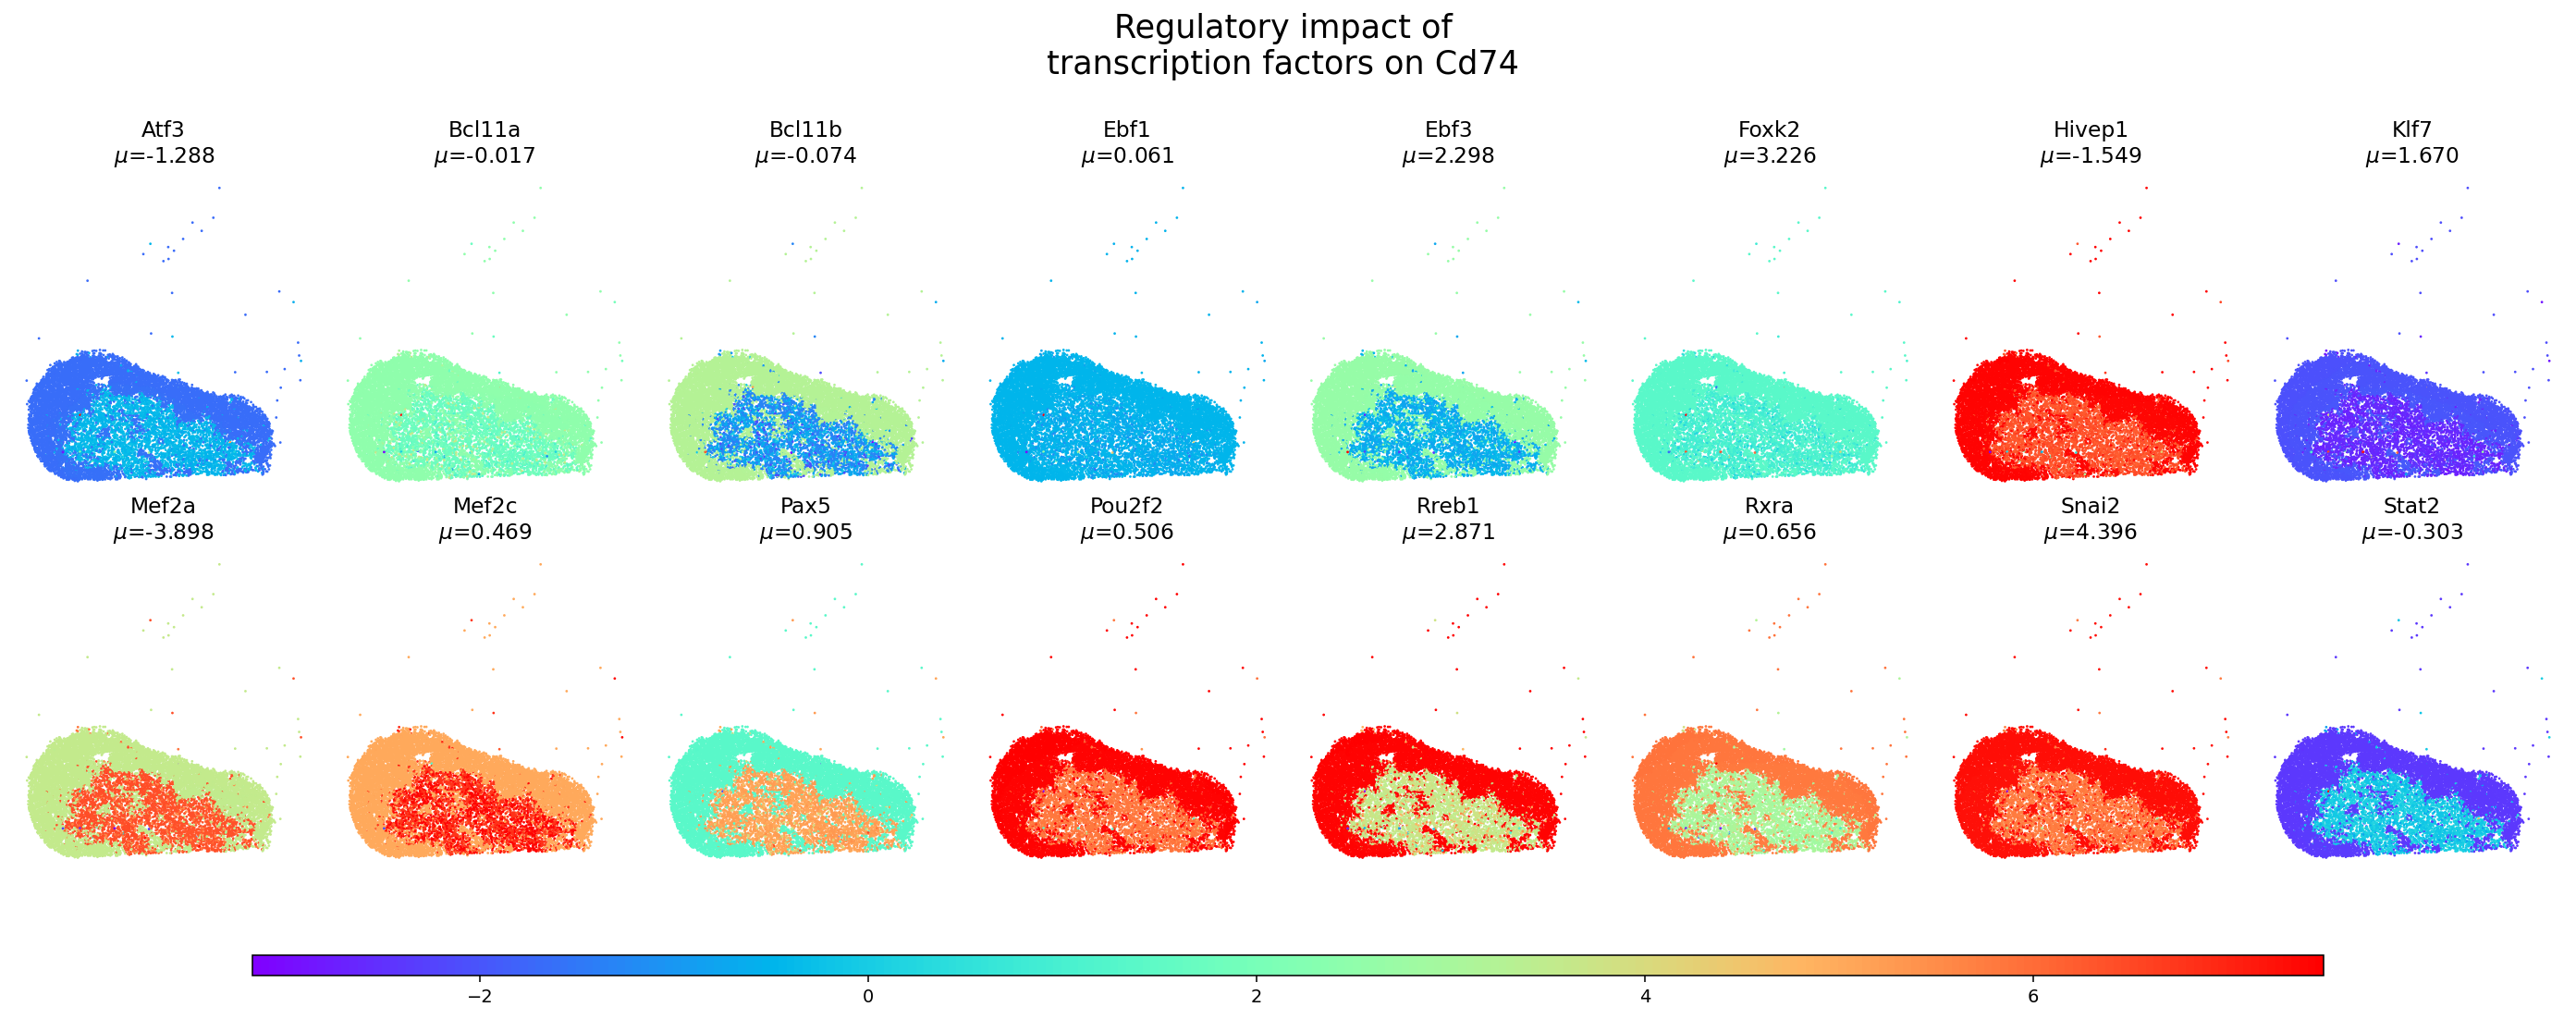

In [ ]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata_test.obsm['spatial'][:, 0], y=adata_test.obsm['spatial'][:, 1], 
                s=2, c=betas_test[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas_test.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

In [ ]:
# Examine attention weights

train_dataloader, valid_dataloader = estimator._build_dataloaders_from_adata(
    estimator.adata.copy(), estimator.target_gene, estimator.regulators, batch_size=1, mode='train', 
    rotate_maps=False, annot='rctd_cluster', spatial_dim=64)


for batch_spatial, batch_x, batch_y, batch_labels in valid_dataloader:
    break

In [ ]:
att_weights = estimator.model.get_att_weights(batch_spatial.to('cuda'))
att_weights[0][0].shape # (nblocks, batch, nheads, patch, patch)

torch.Size([2, 257, 257])

In [ ]:
n_blocks

2

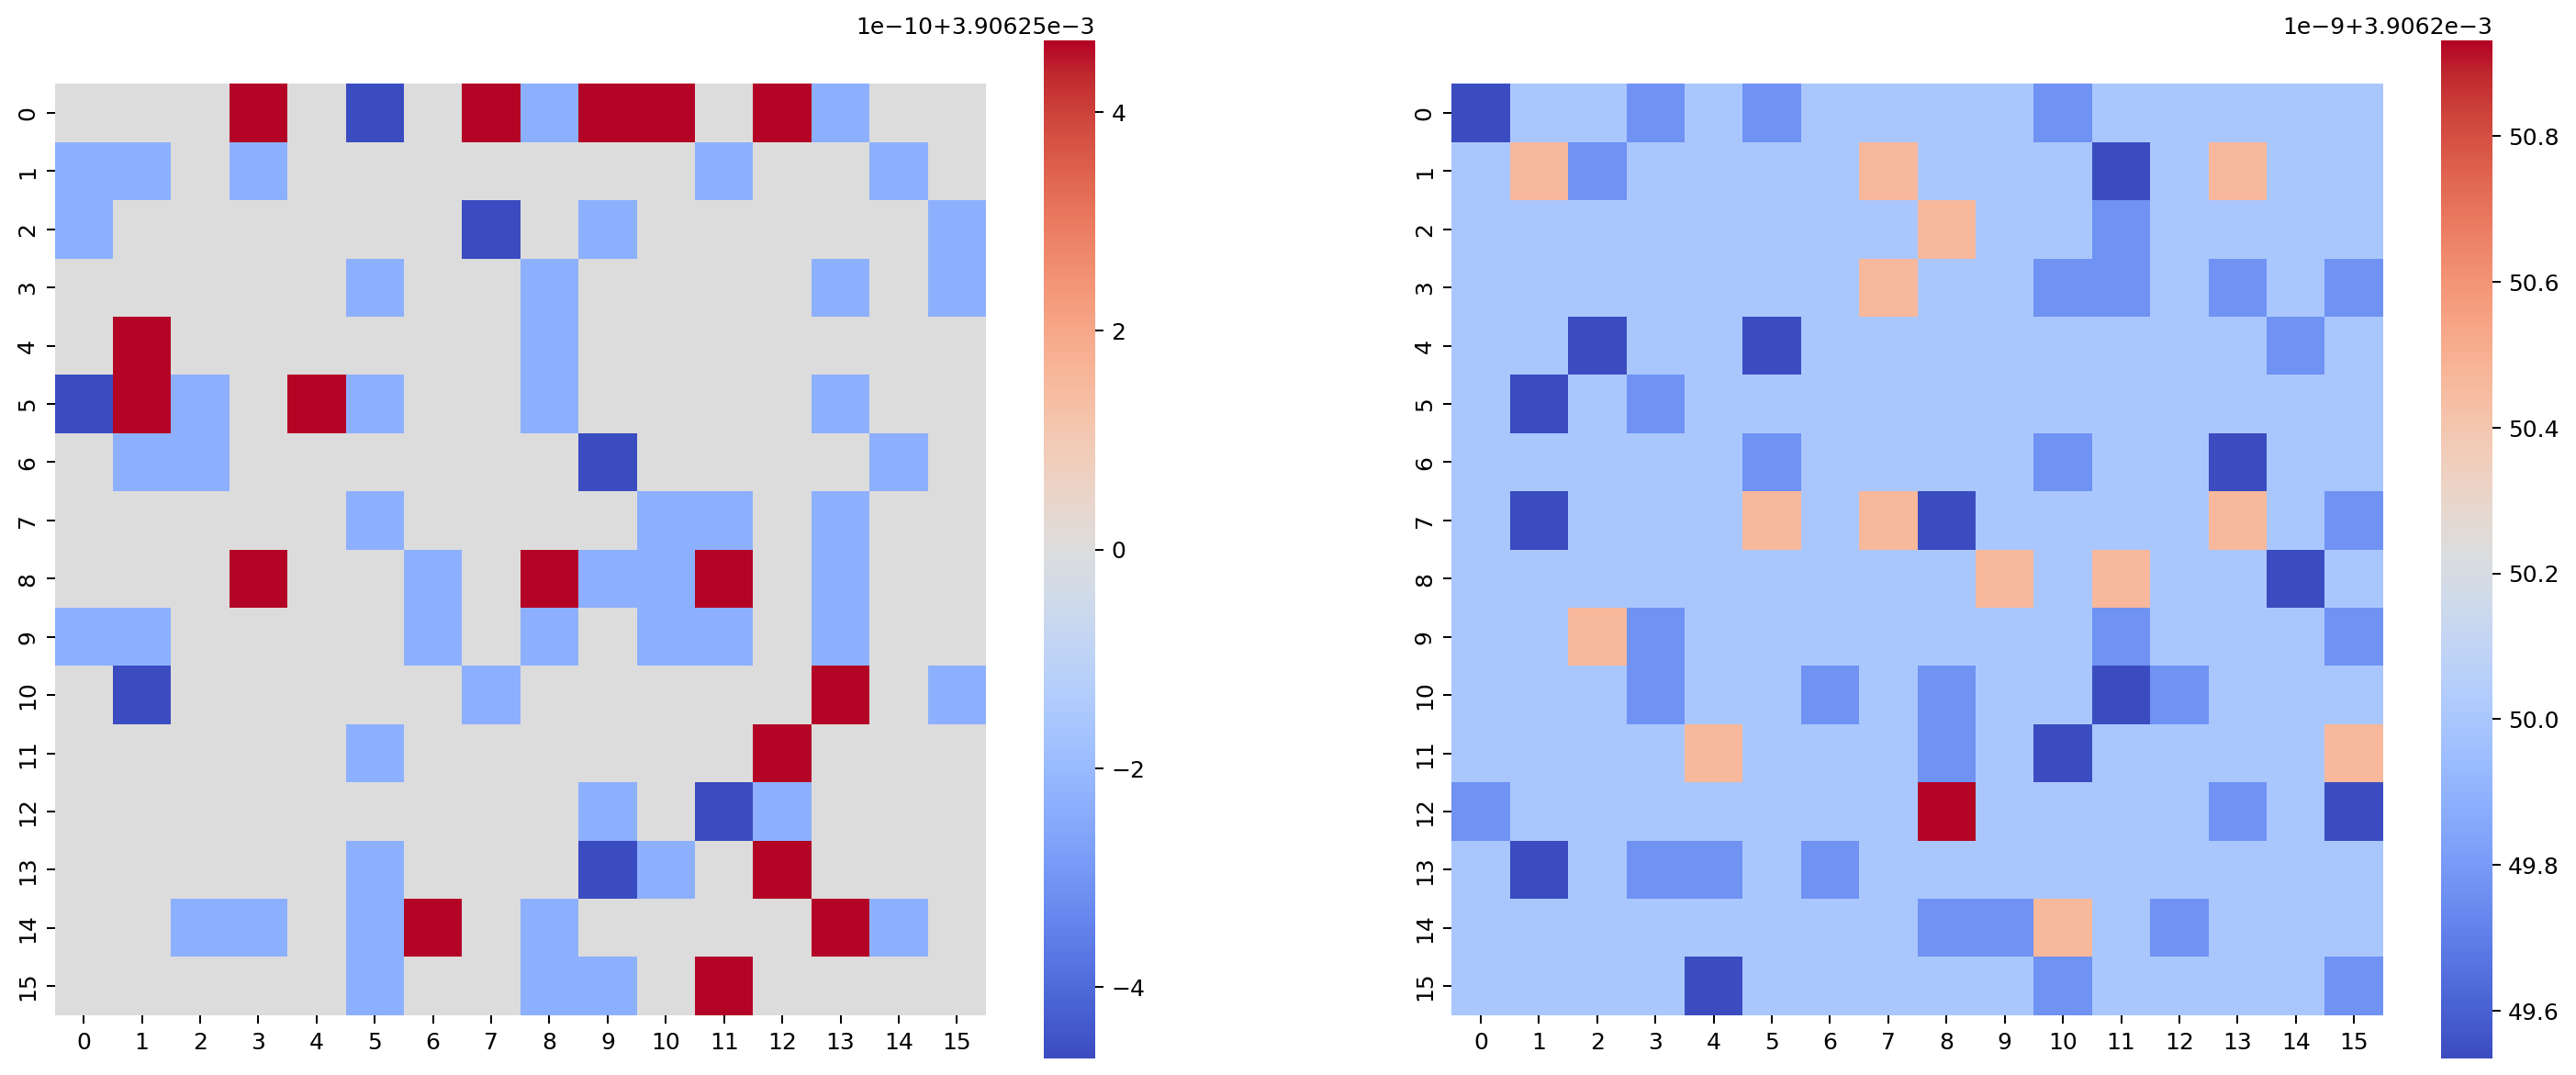

In [ ]:
n_blocks = estimator.model.n_blocks
fig, axs = plt.subplots(ncols=n_blocks, figsize=(20, 8))

# (nblocks, batch, nheads, patch, patch)

for i in range(n_blocks):
    sns.heatmap(att_weights[1][0][i].mean(dim=1).squeeze(0).detach().cpu().numpy()[1:].reshape(16,16), 
                ax=axs[i], cmap='coolwarm', square=True)

<AxesSubplot: >

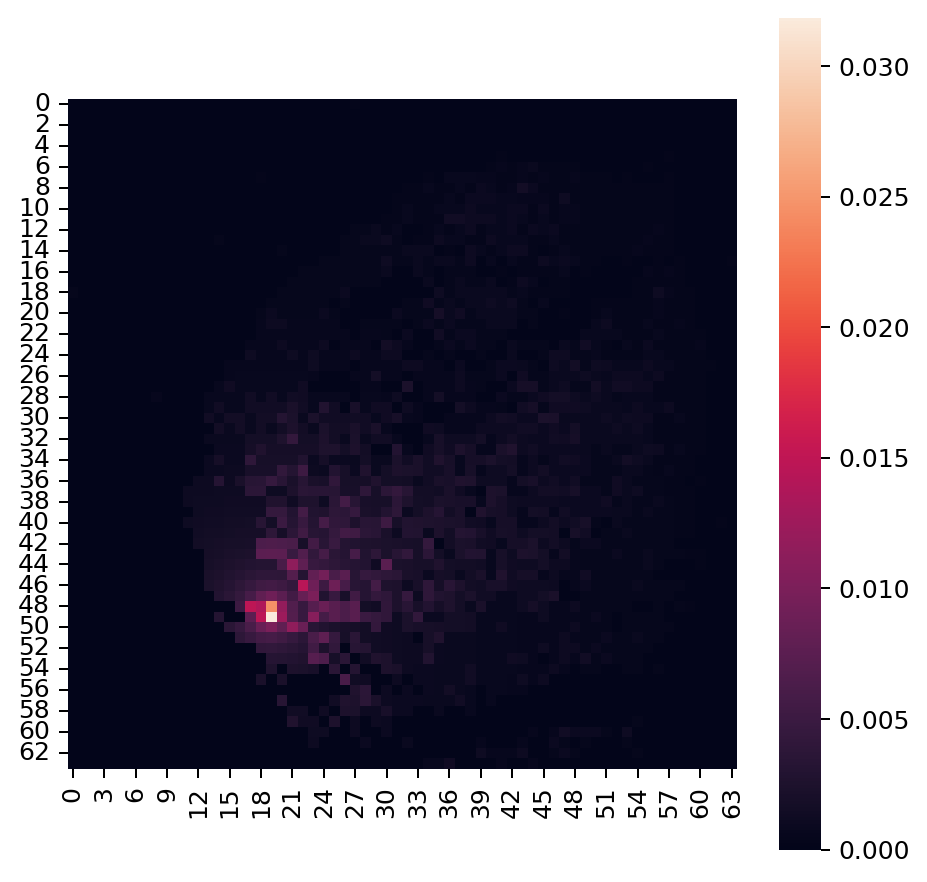

In [ ]:
sns.heatmap(batch_spatial.sum(axis=1).squeeze().detach().cpu().numpy(), square=True)